In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec 17 07:07:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    51W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


# 라이브러리 불러오기

In [2]:
import os 
from skimage import io, transform
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt 
from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init
import torch.nn.functional as F
import torchvision.datasets  as ds
import torchvision.transforms  as tf
from torchvision.transforms import ToTensor, ToPILImage
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from torchvision import transforms

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 레이블 처리

In [3]:
images_folder = '/content/drive/MyDrive/딥프/img'
train_img =pd.read_csv('/content/drive/MyDrive/딥프/csv/train_data2.csv')
test_img =pd.read_csv('/content/drive/MyDrive/딥프/csv/test_data.csv')
#images_title = os.listdir(images_folder)
#images_title.sort()


In [4]:
# N(비녹지): 0, S(반녹지): 1, G(녹지): 2
train_label = []
test_label = []

for i in train_img['0']:
    if 'non_green_space' in i:
        train_label.append(0)

    elif 'green_space_and_road' in i:
        train_label.append(1)

    elif 'green_space_and_etc' in i:
        train_label.append(1)

    elif 'green_space' in i:
        train_label.append(2)


for i in test_img['0']:
    if 'non_green_space' in i:
        test_label.append(0)

    elif 'green_space_and_road' in i:
        test_label.append(1)

    elif 'green_space_and_etc' in i:
        test_label.append(1)

    elif 'green_space' in i:
        test_label.append(2) 

In [5]:
train_data = pd.DataFrame(
    {'image': train_img['0'], 
    'label': train_label})

test_data = pd.DataFrame(
    {'image': test_img['0'], 
    'label': test_label})

In [6]:
train_data_sf = train_data.sample(frac = 1).reset_index(drop = True)
test_data_sf = test_data.sample(frac = 1).reset_index(drop = True)

# 데이터 분리 및 전처리

In [7]:
class ForestDataset(Dataset):

    def __init__(self, dataframe, root_dir, transform = None):

        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, 
                                self.dataframe.iloc[idx,0])
        image = io.imread(img_name)
        
        label = self.dataframe.iloc[idx,1]
        
        if self.transform:

            image = self.transform(image)


        sample = {'image': image, 'label': label}
        return image, label

In [8]:
#train_data_sf = train_data_sf[:500]
test_data_sf = test_data_sf[160:320]

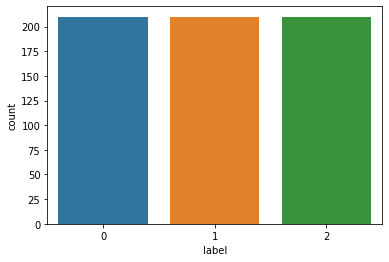

In [9]:
import seaborn as sns

sns.countplot(x = 'label', data = train_data_sf)
plt.show()

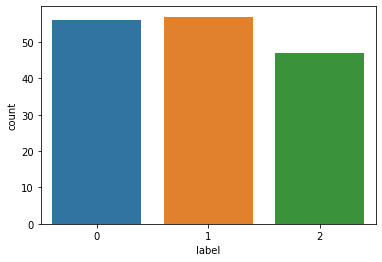

In [ ]:
sns.countplot(x = 'label', data = test_data_sf)
plt.show()

In [ ]:
print('train의 개수: {}'.format(len(train_data_sf)))
print('test의 개수: {}'.format(len(test_data_sf)))

train의 개수: 630
test의 개수: 160


In [10]:
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=(0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [11]:
batch_size = 640

train_dataset = ForestDataset(dataframe = train_data_sf, 
                              root_dir = images_folder, 
                              transform = data_transform)

test_dataset = ForestDataset(dataframe = test_data_sf, 
                             root_dir = images_folder, 
                             transform = data_transform)

train_loader = DataLoader(train_dataset, 
                          batch_size = 128, 
                          shuffle = True, 
                          num_workers = 0)

test_loader = DataLoader(test_dataset, 
                         batch_size = len(test_data), 
                         shuffle = True, 
                         num_workers = 0)

In [12]:
x, y = next(iter(train_loader))

In [ ]:
x.shape

In [ ]:
pil = ToPILImage()

pil(x[4])

In [ ]:
y

# 모델

In [20]:
class VGG11(torch.nn.Module): 

    def __init__(self):
        super().__init__()


        # block 1
        self.layer1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.pool1 = nn.MaxPool2d((2,2), stride = (2,2))
        
        # block 2
        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.pool2 = nn.MaxPool2d((2,2), stride = (2,2))

        # block 3
        self.layer3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.layer4 = nn.Sequential(nn.Conv2d(256, 256, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.pool3 = nn.MaxPool2d((2,2), stride = (2,2))

        # block 4
        self.layer5 = nn.Sequential(nn.Conv2d(256, 512, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.layer6 = nn.Sequential(nn.Conv2d(512, 512, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.pool4 = nn.MaxPool2d((2,2), stride = (2,2))

        # block 5
        self.layer7 = nn.Sequential(nn.Conv2d(512, 512, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.layer8 = nn.Sequential(nn.Conv2d(512, 512, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.pool5 = nn.MaxPool2d((2,2), stride = (2,2))

        # FC Layers
        self.flat = nn.Flatten()

        self.fc1 = nn.Sequential(nn.Linear(512 * 7 * 7, 4096), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(4096, 4096), nn.ReLU())
        self.fc3 = nn.Linear(4096, 3)

        #self.act_funt = nn.Sigmoid()
        self.output = nn.Softmax(dim=1) 




    def forward(self, x):
        
        # block 1
        out = self.layer1(x)
        out = self.pool1(out)

        # block 2
        out = self.layer2(out)
        out = self.pool2(out)

        # block 3
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.pool3(out)

        # block 4
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.pool4(out)

        # block 5
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.pool5(out)

        # fc
        out = self.flat(out)

        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        #out = self.act_funt(out)
        prob = self.output(out)

        return prob


# 모델 불러오기

In [21]:
num_epochs = 100
learning_rate = 0.001

# model = VGG16()
model = VGG11()

# loss
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.RMSprop(model.parameters(), lr = learning_rate)

# scheduler
#scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,lr_lambda=lambda epoch: 0.95 ** epoch)

In [ ]:
model2 = VGG11()

checkpoint = torch.load('./checkpoint-10.pt')
model2.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
checkpoint_epoch = checkpoint["epoch"]
checkpoint_description = checkpoint["description"]

In [22]:
#model2 = VGG11()

PATH = '/content/drive/MyDrive/딥프/csv/vgg11_model_adagrad.pt'
device = torch.device('cpu')
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

# 학습

In [ ]:
train_loss_list = [] 
test_loss_list = []


model.train()

checkpoint = 1
for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(train_loader):
       
        
        # gradient 0으로 초기화
        optimizer.zero_grad()

        # train 데이터 예측
        train_pred = model(x)

        # train loss 계산
        loss = criterion(train_pred, y)
        train_loss = loss.item()

        # loss값 저장
        #train_loss_list.append(train_loss)
        

        # loss 개선
        loss.backward()

        # W와 b를 업데이트
        optimizer.step()

        if (epoch % 5 == 0) :#and (batch_idx == ):
            model.eval()

            # test loss와 accuracy 계산
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    test_pred = model(data)

                    test_loss += criterion(test_pred, target).item()

                    
                    correct += (target == test_pred.argmax(dim = 1)).sum().item()
            test_loss /= len(test_loader)
            test_accuracy = correct/len(test_loader.dataset)


            # loss값 저장
            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)


            # train 정확도 계산
            train_num_correct = (y == train_pred.argmax(dim = 1)).sum().item()
            train_accuracy = train_num_correct / x.shape[0]


            print('Epoch: {} | batch: {} | Training Loss: {:.3f} | Test loss: {:.3f} | train_Accuracy {:2.2f}% | test_Accuracy {:2.2f}%'.format(
                epoch, batch_idx, train_loss, test_loss, train_accuracy*100, test_accuracy*100))
            print('--------------------------------------------------------------------------------------------------------\n')

            """
            torch.save(
                {
                    "model": "CustomModel",
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "cost": test_loss,
                    "description": f"CustomModel 체크포인트-{checkpoint}",
                },
                f"./ada2_checkpoint-{checkpoint}.pt",
            )
            checkpoint += 1
            """

    #scheduler.step()



Epoch: 0 | batch: 0 | Training Loss: 0.614 | Test loss: 1.201 | train_Accuracy 94.53% | test_Accuracy 35.00%
--------------------------------------------------------------------------------------------------------

Epoch: 0 | batch: 1 | Training Loss: 1.286 | Test loss: 1.201 | train_Accuracy 26.56% | test_Accuracy 35.00%
--------------------------------------------------------------------------------------------------------

Epoch: 0 | batch: 2 | Training Loss: 1.247 | Test loss: 1.201 | train_Accuracy 30.47% | test_Accuracy 35.00%
--------------------------------------------------------------------------------------------------------

Epoch: 0 | batch: 3 | Training Loss: 1.184 | Test loss: 1.201 | train_Accuracy 36.72% | test_Accuracy 35.00%
--------------------------------------------------------------------------------------------------------

Epoch: 0 | batch: 4 | Training Loss: 1.179 | Test loss: 1.201 | train_Accuracy 37.29% | test_Accuracy 35.00%
-------------------------------

In [ ]:
torch.save(model.state_dict(), 'vgg11_model1')

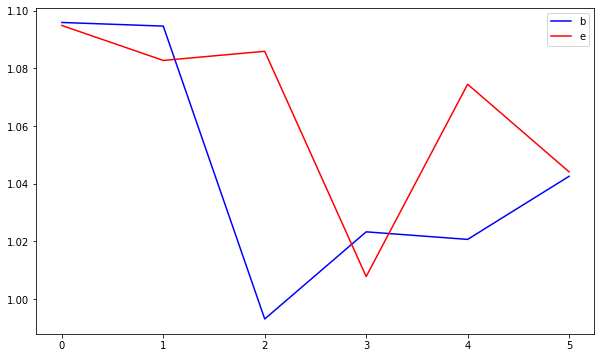

In [ ]:
plt.figure(1, figsize = (10, 6))
plt.plot(train_loss_list, c = 'b', label = 'train_loss')
plt.plot(test_loss_list, c = 'r', label = 'test_loss')
plt.legend('best')
plt.ylim()
plt.show()

# 성능평가

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
model.eval()
test_labels = [] #np.array(None)
pred_labels = [] #np.array(None)

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = output.argmax(dim = 1)

        target = target.detach().numpy()
        pred = pred.detach().numpy()

        test_labels.append(target)
        pred_labels.append(pred)

In [ ]:
test_labels

[array([1, 2, 0, 1, 1, 1, 0, 2, 1, 1, 1, 2, 0, 0, 2, 0, 2, 1, 1, 1, 0, 2,
        2, 1, 1, 2, 2, 2, 1, 0, 0, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2,
        0, 1, 0, 0, 2, 1, 0, 2, 2, 1, 2, 0, 0, 0, 2, 2, 1, 2, 0, 1, 2, 2,
        1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 2, 0, 0, 2, 0, 1, 0, 0, 2, 1, 1,
        2, 1, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 2, 0, 2, 0, 0, 0, 2,
        0, 0, 1, 0, 1, 0, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 1, 2, 0, 1, 2, 0,
        0, 1, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1,
        2, 0, 0, 0, 0, 0])]

In [ ]:
pred_labels

[array([1, 2, 0, 1, 2, 1, 0, 2, 1, 1, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 0, 2,
        2, 1, 1, 2, 2, 2, 1, 0, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2,
        0, 1, 0, 2, 2, 1, 0, 2, 2, 1, 2, 0, 0, 0, 2, 2, 1, 2, 0, 1, 2, 2,
        1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 2, 0, 0, 2, 0, 1, 0, 0, 2, 1, 1,
        2, 1, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 1, 2, 2, 2, 0, 2, 0, 0, 1, 2,
        0, 0, 1, 0, 1, 0, 2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 1, 2, 0, 1, 2, 0,
        0, 1, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 1, 2, 1, 1, 0, 0, 2, 1, 1, 1,
        2, 0, 0, 2, 0, 0])]

In [ ]:
print(classification_report(y_true = test_labels[0], y_pred = pred_labels[0]))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       160
           1       0.95      0.97      0.96       160
           2       0.93      0.97      0.95       160

    accuracy                           0.96       480
   macro avg       0.96      0.96      0.96       480
weighted avg       0.96      0.96      0.96       480



# 

In [ ]:
# 예측이 틀린 인덱스 번호 저장
incorrect_idx = []

# 모델이 예측한 값
model_predict = []

for idx in range(len(test_label)):

    if (pred_labels[0][idx] != test_labels[0][idx]):
        
        incorrect_idx.append(idx)
        model_predict.append(pred_labels[0][idx])


In [ ]:
toPILImage = ToPILImage()

In [ ]:
len(incorrect_idx)

20

In [ ]:
num = 0

f, axarr = plt.subplots(len(incorrect_idx),1,figsize = (300 , 300))

for idx in incorrect_idx:
    axarr[num].imshow(toPILImage(data[idx]))

    axarr[num].title.set_text('predict'+str(model_predict[num])+'\n'+'correct'+str(test_labels[0][idx]))

    num = num + 1

Output hidden; open in https://colab.research.google.com to view.

# 재귀

In [47]:
totensor = ToTensor()

In [116]:
def recursion(img, count):


    count = count

    # 이미지 분리 
    img_list = []

    imgex=pil(img)

    imgex1=imgex.crop((0,0,112,112))
    imgex2=imgex.crop((112,112,224,224))
    imgex3=imgex.crop((0,112,112,224))
    imgex4=imgex.crop((112,0,224,112))

    imgex1=imgex1.resize((224,224))
    imgex2=imgex2.resize((224,224))
    imgex3=imgex3.resize((224,224))
    imgex4=imgex4.resize((224,224))

    img_list.append(totensor(imgex1))
    img_list.append(totensor(imgex2))
    img_list.append(totensor(imgex3))
    img_list.append(totensor(imgex4))

    
    
    # 총 비율
    num = 0

    
    for image1 in img_list:
        
        image2 = image1.reshape(1, image1.shape[0], image1.shape[1], image1.shape[2])
        result = model(image2).argmax(dim = 1)

        if(result == 0):
            
            num = num + 0


        elif(result == 1):

            # 4번까지만 분할
            if(count == 4):

                num = num + (1/2) * (100 * (1/4)**count)

                return num

            else:

                sub_num = recursion(image1, count + 1)

                num = num + sub_num

        elif(result == 2):
            
            num = num + (100 * (1/4)**count)

        
    return num




In [113]:
test = x[40]

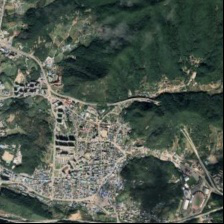

In [114]:
pil(test)

In [117]:
recursion(test, 1)

48.486328125